# Custom Python plugin

## Overview

In Mitsuba it easy to add custom code for BSDFs, integrators, emitters, sensors, and more. This tutorial will show you how to create custom plugins in Python and register them for use.

To illustrate this, we are going to implement a new *tinted dielectric* BSDF, that behaves much like a regular [dielectric BSDF][1] but adds a colorful tint to the reflections at grazing angle. We will then register this new BSDF and use it to render a simple scene.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Create a custom BSDF plugin in Python</li>
  <li>Register a custom plugin to the system</li>
  <li>Use a registered custom plugin</li>
</ul>
    
</div>

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html#smooth-dielectric-material-dielectric

## Setup

Custom Mitsuba plugins written in Python work best with Just-In-Time (JIT) variants. This is because it would be pretty inefficient to execute Python BSDF code for millions of *scalar* light paths. JIT variants, on the other hand, only execute a few calls to those methods on arrays containing millions of entries at once, mitigating the overhead coming from the the Python layer. In this example we will therefore stick with the `llvm_ad_rgb` variant.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Implementation

As mentioned in the tutorial overview, we are going to implement a tinted dielectric BSDF in this tutorial. This code is very similar to the actual [C++ implementation][0] of the [dielectric BSDF][1], so we will not look at it in great detail.

First, our BSDF Python class `MyBSDF` needs to inherit from [<code>BSDF</code>][2]. This allows us to override the constructor method as well as [<code>sample()</code>][3], [<code>eval()</code>][4] and [<code>pdf()</code>][5].

The constructor takes a [<code>Properties</code>][6] object as an argument, which can be used to read parameters defined in the XML scene description or passed in the [<code>load_dict()</code>][7] dictionary. Here we read the index of refraction ratio `eta` as well as the tint color `tint` from `props`. In the constructor, we also properly set the BSDF members used in other methods like `m_flags` and `m_components`.

Similarly to the regular dielectric BSDF, the `eval()` and `pdf()` methods of our custom BSDF should always return `0.0` and never be called as it is a degenerate BSDF described by a Dirac delta distribution.

Regarding the `sample()` method, apart from the computation of the tinted reflection value `value_r`, the rest of code should be identical to the [C++ implementation][0] of `dielectric`.

Note that it is also possible to override the [<code>to_string()</code>][8] method which is called in any printing/logging routine.

Finally, we override the implementation of the [<code>traverse()</code>][9] and [<code>parameters_changed()</code>][10] methods to expose the `tint` parameter via the *traverse* mechanism. This will allow us to edit this parameter after the BSDF is instanciated.

[0]: https://github.com/mitsuba-renderer/mitsuba3/blob/master/src/bsdfs/dielectric.cpp 
[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html#smooth-dielectric-material-dielectric
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF
[4]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF
[5]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF
[6]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Properties
[7]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict
[8]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Object.to_string
[9]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Object.traverse
[10]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Object.parameters_changed

In [2]:
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        # Read 'eta' and 'tint' properties from `props`
        self.eta = 1.33
        if props.has_property('eta'):
            self.eta = props['eta']

        self.tint = props['tint']

        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DeltaReflection   | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        transmission_flags = mi.BSDFFlags.DeltaTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags

    def sample(self, ctx, si, sample1, sample2, active):
        # Compute Fresnel terms
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        r_i, cos_theta_t, eta_it, eta_ti = mi.fresnel(cos_theta_i, self.eta)
        t_i = dr.max(1.0 - r_i, 0.0)

        # Pick between reflection and transmission
        selected_r = (sample1 <= r_i) & active

        # Fill up the BSDFSample struct
        bs = mi.BSDFSample3f()
        bs.pdf = dr.select(selected_r, r_i, t_i)
        bs.sampled_component = dr.select(selected_r, mi.UInt32(0), mi.UInt32(1))
        bs.sampled_type      = dr.select(selected_r, mi.UInt32(+mi.BSDFFlags.DeltaReflection),
                                                     mi.UInt32(+mi.BSDFFlags.DeltaTransmission))
        bs.wo = dr.select(selected_r,
                          mi.reflect(si.wi),
                          mi.refract(si.wi, cos_theta_t, eta_ti))
        bs.eta = dr.select(selected_r, 1.0, eta_it)

        # For reflection, tint based on the incident angle (more tint at grazing angle)
        value_r = dr.lerp(mi.Color3f(self.tint), mi.Color3f(1.0), dr.clamp(cos_theta_i, 0.0, 1.0))

        # For transmission, radiance must be scaled to account for the solid angle compression
        value_t = mi.Color3f(1.0) * dr.sqr(eta_ti)

        value = dr.select(selected_r, value_r, value_t)
        
        return (bs, value)

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def eval_pdf(self, ctx, si, wo, active):
        return 0.0, 0.0

    def traverse(self, callback):
        callback.put_parameter('tint', self.tint, mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        print("🏝️ there is nothing else to do 🏝️")

    def to_string(self):
        return ('MyBSDF[\n'
                '    eta=%s,\n'
                '    tint=%s,\n'
                ']' % (self.eta, self.tint))

## Plugin registration

There's only one more thing to do before we can use our custom BSDF in scenes. We need to register it in the system so it can be used. This can be done by calling the [<code>register_bsdf()</code>][1] function and specifying the name to be used to instantiate this plugin. The function takes a *constructor lambda* function as the second parameter.


<div class="admonition note alert alert-block alert-info">

📑 **Note**
    
Similar functions exist for other types of plugins, e.g. <tt>register_integrator</tt>, <tt>register_sensor</tt>, <tt>register_medium</tt>, ...

</div>

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.register_bsdf

In [3]:
mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))

## Plugin instantiation

You can now use this plugin like you would with any other BSDF plugin and set the appropriate properties of the BSDF expected in its constructor in the XML or `dict` representation.

In [4]:
my_bsdf = mi.load_dict({
    'type' : 'mybsdf',
    'tint' : [0.2, 0.9, 0.2],
    'eta' : 1.33
})

my_bsdf

MyBSDF[
    eta=1.33,
    tint=[0.2, 0.9, 0.2],
]

## Rendering

Finally, let's use our custom BSDF in an actual scene and render it to see how our tinted BSDF looks like.

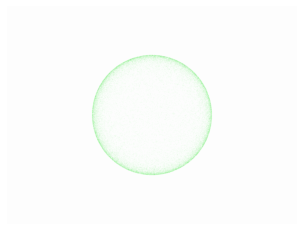

In [5]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': { 
        'type': 'path' 
    },
    'light': { 
        'type': 'constant',
        'radiance': 0.99,
    },
    'sphere' : {
        'type': 'sphere',
        'bsdf': my_bsdf
    },
    'sensor': {
        'type': 'perspective',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, -5, 5], 
                                                 target=[0, 0, 0], 
                                                 up=[0, 0, 1]),
    }
})

image = mi.render(scene)
    
from matplotlib import pyplot as plt
plt.imshow(mi.Bitmap(image).convert(srgb_gamma=True)); 
plt.axis('off');

## Edit parameters

As expected, it is possible to access our custom BSDF's parameters using the [<code>traverse</code>][1] mechanism.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse

In [6]:
params = mi.traverse(scene)
params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  light.radiance.value                 ∂        Float           UniformSpectrum
  sensor.near_clip                              float           PerspectiveCamera
  sensor.far_clip                               float           PerspectiveCamera
  sensor.shutter_open                           float           PerspectiveCamera
  sensor.shutter_open_time                      float           PerspectiveCamera
  sensor.x_fov                                  float           PerspectiveCamera
  sensor.to_world                               Transform4f     PerspectiveCamera
  sphere.to_world                               Transform4f     Sphere
  sphere.bsdf.tint                     ∂        Array3f64       BSDF
]

We can then update the `tint` value:

In [7]:
key = 'sphere.bsdf.tint'
params[key] = mi.ScalarColor3f(0.9, 0.2, 0.2)
params.update()

🏝️ there is nothing else to do 🏝️


When re-rendering this scene, we now see that the new tint is indeed used!

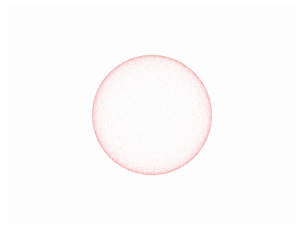

In [8]:
image = mi.render(scene)
    
plt.imshow(mi.Bitmap(image).convert(srgb_gamma=True)); 
plt.axis('off');

## See also

- [<code>mitsuba.BSDF</code>][1]
- [<code>mitsuba.register_bsdf()</code>][2]

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.register_bsdf